# 날씨에 따른 서울 시민의 공공자전거 이용 분석
2023.10.28 ~ 2023.11.21

## 1. 프로젝트 개요

- **주제: 날씨에 따른 서울 시민의 공공자전거 이용 분석**
- 설명: 2022년 1월 ~ 2023년 6월의 서울시 공공자전거 대여소별 이용건수와 기상관측 데이터를 활용하여, 야외 활동이 어려운 날씨일 때 자전거 이용이 유의미하게 감소하는지 확인
- 사용 데이터셋
    - [서울시 공공자전거 이용현황](https://data.seoul.go.kr/dataList/OA-14994/F/1/datasetView.do) : 서울시에서 운영하는 공공자전거(따릉이)에 대한 기간별, 대여소별 이용(대여, 반납)현황 데이터
    - [방재기상관측(AWS)](https://data.kma.go.kr/data/grnd/selectAwsRltmList.do?pgmNo=56) : 지진 · 태풍 · 홍수 · 가뭄 등 기상현상에 따른 자연재해를 막기 위해 실시하는 지상관측 바람, 습도, 기압 데이터
    - [관측지점정보](https://data.kma.go.kr/tmeta/stn/selectStnList.do) : 기상관측 지점에 대한 지점번호, 관측 시작일과 종료일, 위 · 경도 등 이력정보와 주변 환경 등에 대한 정보

## 2. 데이터 로딩 및 EDA

### 2-1. 서울시 공공자전거 이용현황 API

#### 2-1-1. 데이터 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns
from scipy import stats
import pickle
import requests
import json
import math

In [2]:
# 2022년 7월부터 2023년 6월까지의 날짜 생성
months = {
    '2022-07': 31, '2022-08': 31, '2022-09': 30, '2022-10': 31, '2022-11': 30, '2022-12': 31,
    '2023-01': 31, '2023-02': 28, '2023-03': 31, '2023-04': 30, '2023-05': 31, '2023-06': 30
}
dates = []

for month, days in months.items():
    for day in range(1, days + 1):
        dates.append(f'{month}-0{str(day)}' if day < 10 else f'{month}-{str(day)}')
        
print(len(dates))

365


365일의 날짜 생성 완료

In [3]:
sum(months.values())

365

날짜 개수가 제대로 생성된 게 맞다.

In [4]:
results = []

# 365일 전체에 대한 데이터 불러오기
for date in dates:
    n = 0 #한 번에 최대 1000개씩 불러올 수 있어서, 여러 번에 나눠서 불러오기 위한 변수
    while True:
        # URL 구성
        url = f'http://openapi.seoul.go.kr:8088'
        params = {
            'key': '73495157686c6f7537384768786b71',
            'type': 'json',
            'service': 'tbCycleUseStatus',
            'start_index': str(n * 1000 + 1),
            'end_index': str((n + 1) * 1000),
            'start_data': date
        }
        for param in params.values():
            url += '/' + param

        # 완성된 URL로부터 데이터 수신
        response = requests.get(url)

        # 받아온 결과를 utf-8 디코딩
        response_data = response.content.decode('utf-8')

        # JSON 문자열을 딕셔너리로 파싱
        response_dict = json.loads(response_data)

        # 결과를 리스트에 저장하고 다음 페이지로 이동
        # 단, 결과가 없는 경우 해당 날짜를 종료
        try:
            results += response_dict['useStatus']['row']
            n += 1
        except:
            break
    
    print(f'{date} 데이터 수신 완료! 현재 데이터 개수 {len(results)}개')

2022-07-01 데이터 수신 완료! 현재 데이터 개수 2621개
2022-07-02 데이터 수신 완료! 현재 데이터 개수 5242개
2022-07-03 데이터 수신 완료! 현재 데이터 개수 7857개
2022-07-04 데이터 수신 완료! 현재 데이터 개수 10479개
2022-07-05 데이터 수신 완료! 현재 데이터 개수 13101개
2022-07-06 데이터 수신 완료! 현재 데이터 개수 15724개
2022-07-07 데이터 수신 완료! 현재 데이터 개수 18342개
2022-07-08 데이터 수신 완료! 현재 데이터 개수 20961개
2022-07-09 데이터 수신 완료! 현재 데이터 개수 23578개
2022-07-10 데이터 수신 완료! 현재 데이터 개수 26193개
2022-07-11 데이터 수신 완료! 현재 데이터 개수 28815개
2022-07-12 데이터 수신 완료! 현재 데이터 개수 31440개
2022-07-13 데이터 수신 완료! 현재 데이터 개수 33972개
2022-07-14 데이터 수신 완료! 현재 데이터 개수 36595개
2022-07-15 데이터 수신 완료! 현재 데이터 개수 39214개
2022-07-16 데이터 수신 완료! 현재 데이터 개수 41830개
2022-07-17 데이터 수신 완료! 현재 데이터 개수 44450개
2022-07-18 데이터 수신 완료! 현재 데이터 개수 47077개
2022-07-19 데이터 수신 완료! 현재 데이터 개수 49704개
2022-07-20 데이터 수신 완료! 현재 데이터 개수 52329개
2022-07-21 데이터 수신 완료! 현재 데이터 개수 54946개
2022-07-22 데이터 수신 완료! 현재 데이터 개수 57575개
2022-07-23 데이터 수신 완료! 현재 데이터 개수 60195개
2022-07-24 데이터 수신 완료! 현재 데이터 개수 62816개
2022-07-25 데이터 수신 완료! 현재 데이터 개수 65444개
2022-07-26 데이터 수신 완료! 현재 데이터

2023-01-23 데이터 수신 완료! 현재 데이터 개수 543313개
2023-01-24 데이터 수신 완료! 현재 데이터 개수 545839개
2023-01-25 데이터 수신 완료! 현재 데이터 개수 548487개
2023-01-26 데이터 수신 완료! 현재 데이터 개수 551089개
2023-01-27 데이터 수신 완료! 현재 데이터 개수 553747개
2023-01-28 데이터 수신 완료! 현재 데이터 개수 556406개
2023-01-29 데이터 수신 완료! 현재 데이터 개수 559062개
2023-01-30 데이터 수신 완료! 현재 데이터 개수 561743개
2023-01-31 데이터 수신 완료! 현재 데이터 개수 564435개
2023-02-01 데이터 수신 완료! 현재 데이터 개수 567123개
2023-02-02 데이터 수신 완료! 현재 데이터 개수 569811개
2023-02-03 데이터 수신 완료! 현재 데이터 개수 572500개
2023-02-04 데이터 수신 완료! 현재 데이터 개수 575184개
2023-02-05 데이터 수신 완료! 현재 데이터 개수 577867개
2023-02-06 데이터 수신 완료! 현재 데이터 개수 580562개
2023-02-07 데이터 수신 완료! 현재 데이터 개수 583250개
2023-02-08 데이터 수신 완료! 현재 데이터 개수 585946개
2023-02-09 데이터 수신 완료! 현재 데이터 개수 588638개
2023-02-10 데이터 수신 완료! 현재 데이터 개수 591322개
2023-02-11 데이터 수신 완료! 현재 데이터 개수 594014개
2023-02-12 데이터 수신 완료! 현재 데이터 개수 596694개
2023-02-13 데이터 수신 완료! 현재 데이터 개수 599386개
2023-02-14 데이터 수신 완료! 현재 데이터 개수 602079개
2023-02-15 데이터 수신 완료! 현재 데이터 개수 604774개
2023-02-16 데이터 수신 완료! 현재 데이터 개수 607471개


In [5]:
# 데이터프레임 생성
cycle_use_df = pd.DataFrame(results)
cycle_use_df

,STA_LOC,RENT_NM,STAT_DATA,RENT_CNT,RTN_CNT,START_INDEX,END_INDEX
0,양천구,729. 서부식자재마트 건너편,2022-07-01,107,126,0,0
1,양천구,731. 서울시 도로환경관리센터,2022-07-01,102,85,0,0
2,양천구,732. 신월중학교,2022-07-01,74,59,0,0
3,양천구,733. 신정이펜하우스314동,2022-07-01,36,17,0,0
4,양천구,734. 신트리공원 입구,2022-07-01,132,144,0,0
...,...,...,...,...,...,...,...
965407,마포구,426. 서울신용보증재단,2023-06-30,56,55,0,0
965408,양천구,722. 경서농협 버스정류장(우리은행신정동지점방향),2023-06-30,70,71,0,0
965409,양천구,723. SBS방송국,2023-06-30,109,110,0,0
965410,양천구,725. 양강중학교앞 교차로,2023-06-30,42,16,0,0


In [6]:
cycle_use_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 965412 entries, 0 to 965411
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   STA_LOC      965412 non-null  object
 1   RENT_NM      965412 non-null  object
 2   STAT_DATA    965412 non-null  object
 3   RENT_CNT     965412 non-null  object
 4   RTN_CNT      965412 non-null  object
 5   START_INDEX  965412 non-null  int64 
 6   END_INDEX    965412 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 51.6+ MB


In [7]:
cycle_use_df.isna().sum()

STA_LOC        0
RENT_NM        0
STAT_DATA      0
RENT_CNT       0
RTN_CNT        0
START_INDEX    0
END_INDEX      0
dtype: int64

데이터를 간략하게 확인해 본 결과
- 각 컬럼의 이름을 **한글로 변경**해야 할 필요성 느낌
- ```START_INDEX```와 ```END_INDEX```는 뭔지 모르겠으니 삭제
- ```RENT_CNT```와 ```RTN_CNT```는 str로 들어가 있으니 **int로 변경**해야 함

#### 2-1-2. 데이터 확인 및 전처리 (전체)

In [8]:
# 쓸데없는 컬럼 삭제 및 컬럼 이름 한글화
new_cycle_use_df = cycle_use_df.rename(columns={
    'STA_LOC': '그룹명',
    'RENT_NM': '대여소명',
    'STAT_DATA': '대여년월',
    'RENT_CNT': '대여건수',
    'RTN_CNT': '반납건수'
}).drop(['START_INDEX', 'END_INDEX'], axis=1)

new_cycle_use_df

,그룹명,대여소명,대여년월,대여건수,반납건수
0,양천구,729. 서부식자재마트 건너편,2022-07-01,107,126
1,양천구,731. 서울시 도로환경관리센터,2022-07-01,102,85
2,양천구,732. 신월중학교,2022-07-01,74,59
3,양천구,733. 신정이펜하우스314동,2022-07-01,36,17
4,양천구,734. 신트리공원 입구,2022-07-01,132,144
...,...,...,...,...,...
965407,마포구,426. 서울신용보증재단,2023-06-30,56,55
965408,양천구,722. 경서농협 버스정류장(우리은행신정동지점방향),2023-06-30,70,71
965409,양천구,723. SBS방송국,2023-06-30,109,110
965410,양천구,725. 양강중학교앞 교차로,2023-06-30,42,16


In [9]:
# 대여건수와 반납건수 컬럼을 int로 변경
new_cycle_use_df['대여건수'] = new_cycle_use_df['대여건수'].astype(int)
new_cycle_use_df['반납건수'] = new_cycle_use_df['반납건수'].astype(int)

new_cycle_use_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 965412 entries, 0 to 965411
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   그룹명     965412 non-null  object
 1   대여소명    965412 non-null  object
 2   대여년월    965412 non-null  object
 3   대여건수    965412 non-null  int32 
 4   반납건수    965412 non-null  int32 
dtypes: int32(2), object(3)
memory usage: 29.5+ MB


#### 2-1-3. 데이터 확인 및 전처리 (그룹명)

In [15]:
new_cycle_use_df['그룹명'].nunique()

25

In [16]:
new_cycle_use_df['그룹명'].unique()

array(['양천구', '광진구', '은평구', '성동구', '강동구', '강서구', '송파구', '중랑구', '마포구',
       '강북구', '노원구', '도봉구', '금천구', '동작구', '관악구', '서초구', '중구', '종로구',
       '강남구', '서대문구', '성북구', '구로구', '동대문구', '영등포구', '용산구'], dtype=object)

25개 행정구에 대한 데이터임을 확인

In [10]:
# 행정구별 행 개수 확인
rows_by_group = new_cycle_use_df['그룹명'].value_counts().sort_values(ascending=False).to_frame()

rows_by_group

,그룹명
송파구,76772
강서구,66719
강남구,57941
영등포구,52953
서초구,50162
노원구,48247
마포구,43607
강동구,43223
구로구,39230
양천구,39088


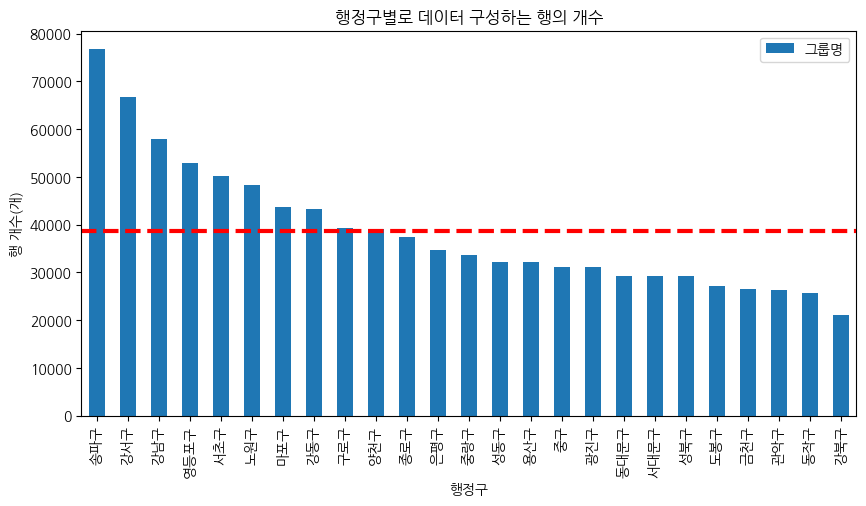

In [11]:
# 시각화
rows_by_group.plot(kind='bar', figsize=(10, 5))
plt.title('행정구별로 데이터 구성하는 행의 개수')
plt.xlabel('행정구')
plt.ylabel('행 개수(개)')
plt.axhline(rows_by_group.mean().values[0], color='red', linestyle='--', linewidth='3')
plt.show()

데이터 개수가 평균보다 많은 곳은 **송파구, 강서구, 강남구, 영등포구, 서초구, 노원구, 마포구, 강동구, 구로구, 양천구**

In [12]:
rows_by_group.loc['양천구'].values[0] > rows_by_group.mean().values[0]

True

사실 양천구는 아리까리해서 직접 확인해봤다

In [13]:
# 행정구별 총 대여건수와 총 반납건수 확인
sum_by_group = new_cycle_use_df.groupby('그룹명').agg({'대여건수': 'sum', '반납건수': 'sum'})
sum_by_group['합계'] = sum_by_group['대여건수'] + sum_by_group['반납건수']
sum_by_group = sum_by_group.sort_values('합계', ascending=False)
sum_by_group

,대여건수,반납건수,합계
그룹명,,,
강서구,5056618,5040945,10097563
송파구,4100810,4081578,8182388
영등포구,3602857,3541017,7143874
노원구,2612017,2602336,5214353
양천구,2563545,2570882,5134427
마포구,2222443,2228658,4451101
광진구,2116380,2083338,4199718
강동구,1938890,1956783,3895673
구로구,1727783,1717980,3445763


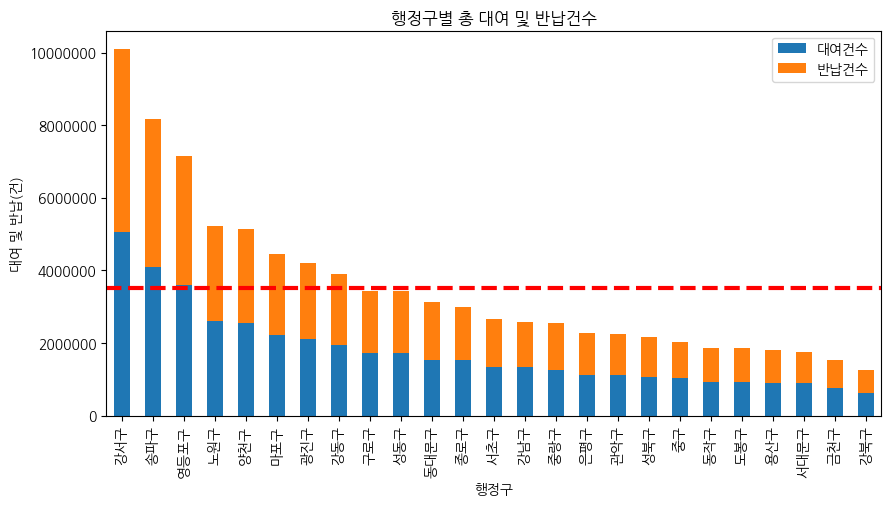

In [14]:
# 시각화
sum_by_group[['대여건수', '반납건수']].plot(kind='bar', figsize=(10, 5), stacked=True)
plt.title('행정구별 총 대여 및 반납건수')
plt.xlabel('행정구')
plt.ylabel('대여 및 반납(건)')
plt.ticklabel_format(axis='y',useOffset=False, style='plain')
plt.axhline(sum_by_group['합계'].mean(), color='red', linestyle='--', linewidth='3')
plt.show()

총 대여 및 반납건수가 평균 이상인 곳은 **강서구, 송파구, 영등포구, 노원구, 양천구, 마포구, 광진구**

#### 2-1-4. 데이터 확인 및 전처리 (대여소명)

In [17]:
# 대여소 개수
new_cycle_use_df['대여소명'].nunique()

2775

대여소 종류가 2775개나 된다.

In [18]:
# 행정구별 대여소 개수 
station_in_group = new_cycle_use_df.groupby('그룹명').agg({'대여소명': 'nunique'}).sort_values('대여소명', ascending=False)
station_in_group

,대여소명
그룹명,
송파구,225
강서구,192
강남구,166
영등포구,153
서초구,150
노원구,139
강동구,123
마포구,123
구로구,114


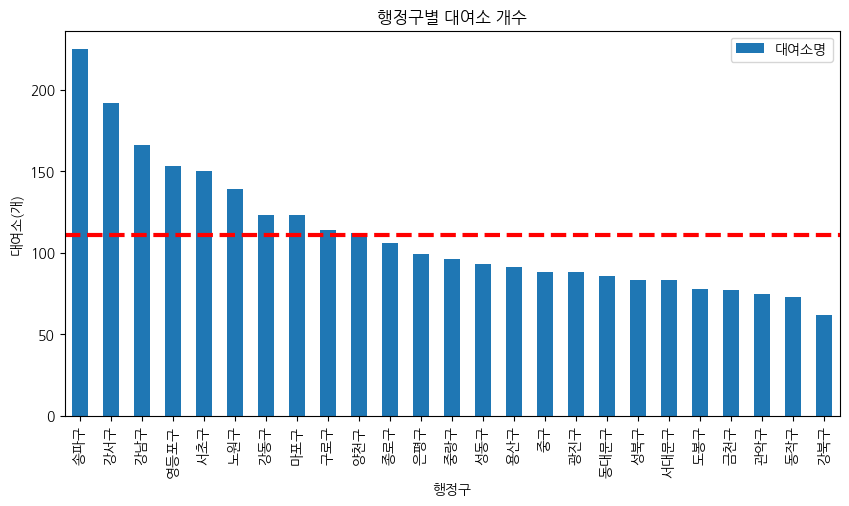

In [19]:
# 시각화
station_in_group.plot(kind='bar', figsize=(10, 5))
plt.title('행정구별 대여소 개수')
plt.xlabel('행정구')
plt.ylabel('대여소(개)')
plt.axhline(station_in_group.mean().values[0], color='red', linestyle='--', linewidth='3')
plt.show()

어디서 본 그래프 같네...? 사실 날짜별로 대여소마다의 데이터가 구성되어 있을 테니 행의 개수가 곧 대여소 개수였을 것이다...!

#### 2-1-5. 데이터 확인 및 전처리 (대여년월)

In [20]:
len(dates)

365

365일 모두 제대로 불러와졌는지 확인하기

In [21]:
new_cycle_use_df['대여년월'].nunique()

364

In [22]:
new_cycle_use_df['대여년월'].nunique() == len(dates)

False

뭔가 문제가 있는 것 같으니 직접 확인해보자

In [24]:
unique_dates = list(new_cycle_use_df['대여년월'].unique())

for date in dates:
    if date not in unique_dates:
        print(date)

2023-06-26


**2023년 6월 26일이 누락**되어 있다

#### 2-1-6. 데이터 확인 및 전처리 (대여건수, 반납건수)

정수형 데이터들이니까 분포를 보자.

In [25]:
new_cycle_use_df[['대여건수', '반납건수']].describe()

,대여건수,반납건수
count,965412.000000,965412.000000
mean,45.702499,45.335170
std,50.114483,51.810103
min,0.000000,0.000000
25%,14.000000,12.000000
50%,31.000000,30.000000
75%,61.000000,61.000000
max,1507.000000,1630.000000


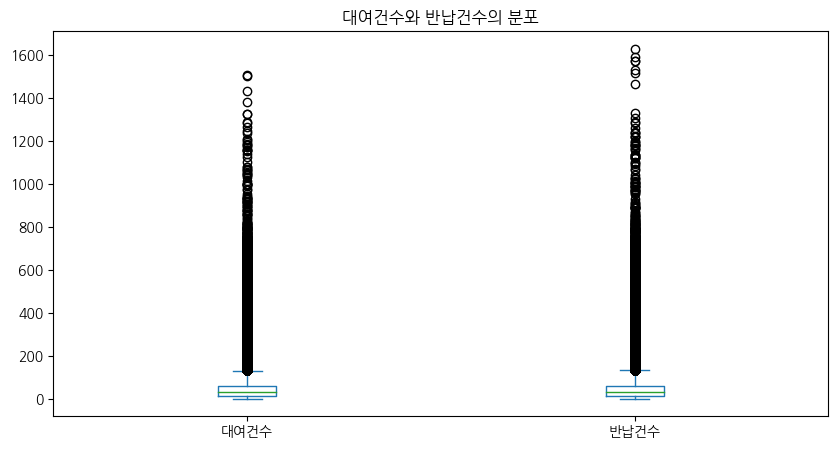

In [26]:
new_cycle_use_df[['대여건수', '반납건수']].plot(kind='box', figsize=(10, 5))
plt.title('대여건수와 반납건수의 분포')
plt.show()

대략 30~40건 내외가 일반적인 것 같다.

그런데 하루 동안 대여소에서 1507건의 대여와 1630건의 반납이 발생하는 경우가 있다고...?

In [28]:
new_cycle_use_df[new_cycle_use_df['대여건수'] == new_cycle_use_df['대여건수'].max()]

,그룹명,대여소명,대여년월,대여건수,반납건수
151854,마포구,4217. 한강공원 망원나들목,2022-08-28,1507,1531


In [29]:
new_cycle_use_df[new_cycle_use_df['반납건수'] == new_cycle_use_df['반납건수'].max()]

,그룹명,대여소명,대여년월,대여건수,반납건수
150077,광진구,502. 뚝섬유원지역 1번출구 앞,2022-08-27,1432,1630


8월 27일과 28일에 한강공원 인근 대여소에서 발생한 기록들이다.

#### 2-1-7. 데이터프레임 저장

In [30]:
new_cycle_use_df

,그룹명,대여소명,대여년월,대여건수,반납건수
0,양천구,729. 서부식자재마트 건너편,2022-07-01,107,126
1,양천구,731. 서울시 도로환경관리센터,2022-07-01,102,85
2,양천구,732. 신월중학교,2022-07-01,74,59
3,양천구,733. 신정이펜하우스314동,2022-07-01,36,17
4,양천구,734. 신트리공원 입구,2022-07-01,132,144
...,...,...,...,...,...
965407,마포구,426. 서울신용보증재단,2023-06-30,56,55
965408,양천구,722. 경서농협 버스정류장(우리은행신정동지점방향),2023-06-30,70,71
965409,양천구,723. SBS방송국,2023-06-30,109,110
965410,양천구,725. 양강중학교앞 교차로,2023-06-30,42,16


In [42]:
with open('new_cycle_use_df.pkl', 'wb') as file:
    pickle.dump(new_cycle_use_df, file)
    print("저장 완료")

저장 완료


### 2-2. 방재기상관측(AWS) 데이터

#### 2-3-1. 데이터 로딩

In [43]:
weather_df = pd.concat([
    pd.read_csv('OBS_AWS_TIM_20231104164010.csv', encoding='cp949'),
    pd.read_csv('OBS_AWS_TIM_20231106144425.csv', encoding='cp949')
])

weather_df

,지점,지점명,일시,기온(°C),풍향(deg),풍속(m/s),강수량(mm),현지기압(hPa),해면기압(hPa),습도(%)
0,116,관악(레),2022-01-01 00:00,-12.0,6.3,5.1,0.0,NaN,NaN,46.0
1,116,관악(레),2022-01-01 01:00,-12.3,355.6,3.6,0.0,NaN,NaN,47.0
2,116,관악(레),2022-01-01 02:00,-12.0,346.6,4.8,0.0,NaN,NaN,54.0
3,116,관악(레),2022-01-01 03:00,-11.5,7.0,5.1,0.0,NaN,NaN,54.0
4,116,관악(레),2022-01-01 04:00,-11.0,13.2,6.2,0.0,NaN,NaN,40.0
...,...,...,...,...,...,...,...,...,...,...
121614,889,현충원,2023-06-30 19:00,28.2,209.4,0.7,0.0,998.7,1000.5,89.0
121615,889,현충원,2023-06-30 20:00,25.8,0.0,0.4,0.0,999.4,1001.2,98.0
121616,889,현충원,2023-06-30 21:00,24.8,0.0,0.3,0.0,1000.0,1001.8,100.0
121617,889,현충원,2023-06-30 22:00,24.2,0.0,0.2,0.0,1000.7,1002.5,100.0


In [44]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366378 entries, 0 to 121618
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   지점         366378 non-null  int64  
 1   지점명        366378 non-null  object 
 2   일시         366378 non-null  object 
 3   기온(°C)     364641 non-null  float64
 4   풍향(deg)    365557 non-null  float64
 5   풍속(m/s)    365638 non-null  float64
 6   강수량(mm)    363032 non-null  float64
 7   현지기압(hPa)  153818 non-null  float64
 8   해면기압(hPa)  153812 non-null  float64
 9   습도(%)      313353 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 30.7+ MB


데이터 모양을 살펴본 결과
- 관측 지점과 대여소 간의 매핑 필요
- 일시는 날짜(yyyy-mm-dd)에 더해 **시간(hh:mm) 단위로 들어가 있음** → 추후 일 단위로 집계 필요할 수 있음
- 풍향(deg), 현지기압(hPa), 해면기압(hPa) 컬럼은 안 쓰일 듯

In [45]:
dropped_weather_df = weather_df.drop([
    '풍향(deg)', '현지기압(hPa)', '해면기압(hPa)' 
], axis=1)

dropped_weather_df

,지점,지점명,일시,기온(°C),풍속(m/s),강수량(mm),습도(%)
0,116,관악(레),2022-01-01 00:00,-12.0,5.1,0.0,46.0
1,116,관악(레),2022-01-01 01:00,-12.3,3.6,0.0,47.0
2,116,관악(레),2022-01-01 02:00,-12.0,4.8,0.0,54.0
3,116,관악(레),2022-01-01 03:00,-11.5,5.1,0.0,54.0
4,116,관악(레),2022-01-01 04:00,-11.0,6.2,0.0,40.0
...,...,...,...,...,...,...,...
121614,889,현충원,2023-06-30 19:00,28.2,0.7,0.0,89.0
121615,889,현충원,2023-06-30 20:00,25.8,0.4,0.0,98.0
121616,889,현충원,2023-06-30 21:00,24.8,0.3,0.0,100.0
121617,889,현충원,2023-06-30 22:00,24.2,0.2,0.0,100.0


In [46]:
dropped_weather_df.isna().sum()

지점             0
지점명            0
일시             0
기온(°C)      1737
풍속(m/s)      740
강수량(mm)     3346
습도(%)      53025
dtype: int64

데이터가 누락된 경우에 대한 처리는
- 기온, 풍속, 습도: 이전 데이터와 다음 데이터 사이의 linear interpolation으로 하면 되지 않을까?
- 강수량: 0으로 넣는 게 낫지 않을까?

자세한 건 데이터 모양 직접 보면서 고민하기

#### 2-3-2. 데이터 확인 및 전처리 (지점, 지점명)

In [47]:
dropped_weather_df['지점'].unique()

array([116, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411,
       412, 413, 414, 415, 416, 417, 418, 419, 421, 423, 424, 425, 509,
       510, 889], dtype=int64)

In [48]:
dropped_weather_df['지점명'].unique()

array(['관악(레)', '강남', '서초', '강동', '송파', '강서', '양천', '도봉', '노원', '동대문',
       '중랑', '기상청', '마포', '서대문', '광진', '성북', '용산', '은평', '금천', '한강', '중구',
       '성동', '구로', '강북', '남현', '관악', '영등포 ', '현충원'], dtype=object)

#### 2-3-3. 데이터 확인 및 전처리 (일시)

In [49]:
dropped_weather_df['일시']

0         2022-01-01 00:00
1         2022-01-01 01:00
2         2022-01-01 02:00
3         2022-01-01 03:00
4         2022-01-01 04:00
                ...       
121614    2023-06-30 19:00
121615    2023-06-30 20:00
121616    2023-06-30 21:00
121617    2023-06-30 22:00
121618    2023-06-30 23:00
Name: 일시, Length: 366378, dtype: object

날짜와 시간을 분리하여 파생 컬럼 만들 필요 있을 것 같다.

In [50]:
dropped_weather_df['날짜'] = dropped_weather_df['일시'].str.split(' ').str[0]
dropped_weather_df['시간'] = dropped_weather_df['일시'].str.split(' ').str[1]
dropped_weather_df

,지점,지점명,일시,기온(°C),풍속(m/s),강수량(mm),습도(%),날짜,시간
0,116,관악(레),2022-01-01 00:00,-12.0,5.1,0.0,46.0,2022-01-01,00:00
1,116,관악(레),2022-01-01 01:00,-12.3,3.6,0.0,47.0,2022-01-01,01:00
2,116,관악(레),2022-01-01 02:00,-12.0,4.8,0.0,54.0,2022-01-01,02:00
3,116,관악(레),2022-01-01 03:00,-11.5,5.1,0.0,54.0,2022-01-01,03:00
4,116,관악(레),2022-01-01 04:00,-11.0,6.2,0.0,40.0,2022-01-01,04:00
...,...,...,...,...,...,...,...,...,...
121614,889,현충원,2023-06-30 19:00,28.2,0.7,0.0,89.0,2023-06-30,19:00
121615,889,현충원,2023-06-30 20:00,25.8,0.4,0.0,98.0,2023-06-30,20:00
121616,889,현충원,2023-06-30 21:00,24.8,0.3,0.0,100.0,2023-06-30,21:00
121617,889,현충원,2023-06-30 22:00,24.2,0.2,0.0,100.0,2023-06-30,22:00


#### 2-3-4. 데이터 확인 및 전처리 (기온)

In [51]:
dropped_weather_df['기온(°C)'].describe()

count    364641.000000
mean         12.387226
std          10.828637
min         -22.100000
25%           3.700000
50%          13.400000
75%          21.500000
max          36.900000
Name: 기온(°C), dtype: float64

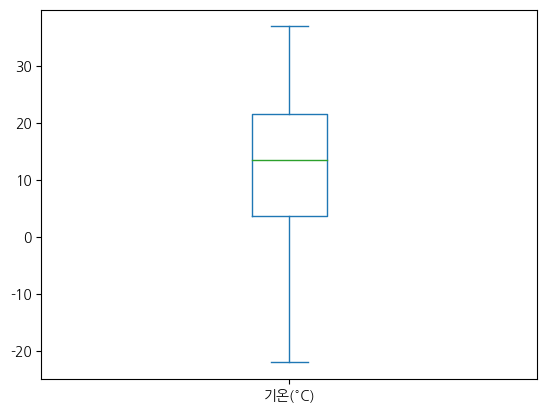

In [52]:
dropped_weather_df['기온(°C)'].plot(kind='box')
plt.show()

대략 5도 근방에서 20도 정도까지에 데이터들이 몰려있는 것 같다. 이상치로 영하 20도 이하의 데이터도 있다!

#### 2-3-5. 데이터 확인 및 전처리 (바람)

In [53]:
dropped_weather_df['풍속(m/s)'].describe()

count    365638.000000
mean          1.669343
std           1.150438
min           0.000000
25%           0.800000
50%           1.500000
75%           2.300000
max          14.600000
Name: 풍속(m/s), dtype: float64

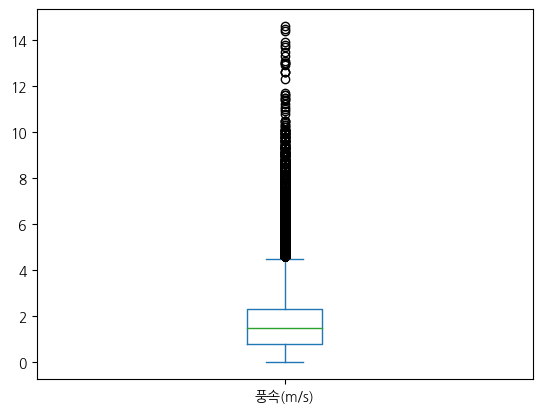

In [54]:
dropped_weather_df['풍속(m/s)'].plot(kind='box')
plt.show()

풍속은 대체로 잔잔한 편인 경우가 많지만 좀 바람이 세게 불면 그게 다 이상치로 측정되는 모양이다.

#### 2-3-6. 데이터 확인 및 전처리 (비)

In [55]:
dropped_weather_df[dropped_weather_df['강수량(mm)'] > 0].count()

지점         18395
지점명        18395
일시         18395
기온(°C)     18339
풍속(m/s)    18372
강수량(mm)    18395
습도(%)      15475
날짜         18395
시간         18395
dtype: int64

비가 왔는지 안 왔는지를 표현해 주는 컬럼이 필요할 듯하다.

In [56]:
dropped_weather_df['강수여부'] = dropped_weather_df['강수량(mm)'].apply(
    lambda x:1 if x > 0 else 0
)

dropped_weather_df[dropped_weather_df['강수여부'] == 1]

,지점,지점명,일시,기온(°C),풍속(m/s),강수량(mm),습도(%),날짜,시간,강수여부
240,116,관악(레),2022-01-11 00:00,-3.3,4.0,0.5,97.0,2022-01-11,00:00,1
241,116,관악(레),2022-01-11 01:00,-5.0,4.1,0.5,96.0,2022-01-11,01:00,1
749,116,관악(레),2022-02-01 05:00,-5.8,3.8,0.5,95.0,2022-02-01,05:00,1
751,116,관악(레),2022-02-01 07:00,-6.2,3.6,0.5,94.0,2022-02-01,07:00,1
1073,116,관악(레),2022-02-14 17:00,-1.1,3.4,0.5,98.0,2022-02-14,17:00,1
...,...,...,...,...,...,...,...,...,...,...
121587,889,현충원,2023-06-29 16:00,23.3,0.5,16.0,100.0,2023-06-29,16:00,1
121590,889,현충원,2023-06-29 19:00,24.3,2.0,0.5,100.0,2023-06-29,19:00,1
121591,889,현충원,2023-06-29 20:00,24.1,1.6,0.5,100.0,2023-06-29,20:00,1
121592,889,현충원,2023-06-29 21:00,24.0,1.5,0.5,100.0,2023-06-29,21:00,1


In [59]:
dropped_weather_df['강수여부'].value_counts(normalize=True)

0    0.949792
1    0.050208
Name: 강수여부, dtype: float64

비오는 날이 전체의 약 5.02%정도 되는 듯

#### 2-3-7. 데이터 확인 및 전처리 (습도)

In [60]:
dropped_weather_df['습도(%)'].describe()

count    313353.000000
mean         60.980240
std          21.577159
min           5.000000
25%          44.000000
50%          61.000000
75%          78.000000
max         100.000000
Name: 습도(%), dtype: float64

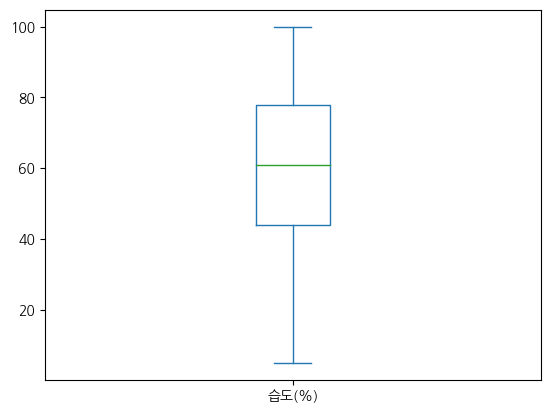

In [61]:
dropped_weather_df['습도(%)'].plot(kind='box')
plt.show()

습도는 40~80% 범위에서 예쁘게 분포되어 있다.

#### 2-3-8. 파생 변수 생성 (체감온도)

체감온도는 인간이 느끼는 더위나 추위를 수량적으로 나타내는 지표이다. 본 분석에서 '날씨가 좋을 때'를 나타내는 파생 지표로써 활용하기에 정말 좋을 것으로 보인다. 기상청에서는 동절기(10월\~4월), 하절기(5월\~9월)를 구분하여 체감온도를 산출한다.

$$T_{wcs} = -0.2442 + 0.55399T_w + 0.45535T_a – 0.0022{T_w}^2 + 0.00278T_wT_a + 3.0$$
$$T_{wcw} = 13.12 + 0.6215T_a - 11.37V^{0.16} + 0.3965V^{0.16}T_a$$

이때 $T_{wcs}$: 여름철 체감온도, $T_{wcw}$: 겨울철 체감온도, $T_a$: 기온(°C), $T_w$: 습구온도(Stull의 추정식 이용), $RH$: 상대습도(%), $V$: 10분 평균 풍속(km/h)이다. 겨울철 체감온도는 기온 10°C 이하, 풍속 1.3 m/s 이상일 때에만 산출한다.

습구온도($T_w$)를 구하기 위한 [Stull의 추정식](https://open.library.ubc.ca/media/stream/pdf/52383/1.0041967/1)[1]은 아래와 같다.

$$T_w = T_a{tan}^{-1}(0.151977(RH+8.313659)^{0.5})+{tan}^{-1}(T_a+RH)-{tan}^{-1}(RH-1.67633)$$
$$+{0.00391838RH}^{1.5}{tan}^{-1}(0.023101RH)-4.686035$$

이상의 공식을 활용하여, 체감온도 파생 변수를 만들고 이를 이용해 분석을 진행해 보도록 한다.

---
[1] Stull, R. (2011). Wet-bulb temperature from relative humidity and air temperature. *J. Appl. Meteorol. Climatol.*, Vol. 50, pp.2267-2269.

In [62]:
def get_tw(ta, rh):
    '''
    Stull의 추정식을 이용하여, 온도와 습도로부터 습구온도를 계산하는 함수
    '''
    tw = ta * math.atan(0.151977 * ((rh + 8.313659) ** 0.5))
    tw += math.atan(ta + rh)
    tw -= math.atan(rh - 1.67633)
    tw += (0.00391838 * (rh ** 1.5) * math.atan(0.023101 * rh))
    tw -= 4.686035
    return tw

def get_summer_twc(ta, rh):
    '''
    온도, 습도를 통해 여름철의 체감온도를 계산하는 함수
    '''
    tw = get_tw(ta, rh) 
    twcs = -0.2442 + (0.55399 * tw) + (0.45535 * ta) - (0.0022 * (tw ** 2)) + (0.00278 * tw * ta) + 3.0
    return twcs

def get_winter_twc(ta, v):
    '''
    온도, 풍속을 통해 겨울철의 체감온도를 계산하는 함수
    '''
    if ta <= 10 and v >= 1.3:
        twcw = 13.12 + (0.6215 * ta) - (11.37 * (v ** 0.16)) + (0.3965 * (v ** 0.16) * ta)
    else:
        twcw = ta
    return min(twcw, ta)

def get_twc(row):
    '''
    데이터프레임 한 줄을 받았을 때 해당 줄의 체감온도를 알아서 계산해 주는 함수
    '''
    month = row['날짜'].split('-')[1]
    ta, v, rh = row['기온(°C)'], row['풍속(m/s)'], row['습도(%)']
    
    if month in ['05', '06', '07', '08', '09']:
        return get_summer_twc(ta, rh)
    else:
        return get_winter_twc(ta, v)

제대로 작동되는지 테스트해보자.

In [90]:
# 테스트해보기
print("여름철:", get_summer_twc(28.6, 85))
print("겨울철:", get_winter_twc(9.4, 6.1))

여름철: 31.030348083019742
겨울철: 8.754798314643951


기상청 날씨누리에서 임의 데이터 하나 긁어서 넣은 건데, **여름철은 제대로 나오고**, 겨울철은 조금 고민이 필요하다. 일단 함수는 잘 작동하는데, 다만 데이터에서 제공되는 게 1시간 평균 풍속이기 때문이다. 체감온도에 10분 평균 풍속을 넣어야 해서 조금 부정확한 결과가 나올 수 있다.

In [63]:
dropped_weather_df['체감온도'] = dropped_weather_df.apply(get_twc, axis=1)
dropped_weather_df

,지점,지점명,일시,기온(°C),풍속(m/s),강수량(mm),습도(%),날짜,시간,강수여부,체감온도
0,116,관악(레),2022-01-01 00:00,-12.0,5.1,0.0,46.0,2022-01-01,00:00,0,-15.269085
1,116,관악(레),2022-01-01 01:00,-12.3,3.6,0.0,47.0,2022-01-01,01:00,0,-14.466980
2,116,관악(레),2022-01-01 02:00,-12.0,4.8,0.0,54.0,2022-01-01,02:00,0,-15.067036
3,116,관악(레),2022-01-01 03:00,-11.5,5.1,0.0,54.0,2022-01-01,03:00,0,-14.701044
4,116,관악(레),2022-01-01 04:00,-11.0,6.2,0.0,40.0,2022-01-01,04:00,0,-14.781080
...,...,...,...,...,...,...,...,...,...,...,...
121614,889,현충원,2023-06-30 19:00,28.2,0.7,0.0,89.0,2023-06-30,19:00,0,30.914765
121615,889,현충원,2023-06-30 20:00,25.8,0.4,0.0,98.0,2023-06-30,20:00,0,29.069218
121616,889,현충원,2023-06-30 21:00,24.8,0.3,0.0,100.0,2023-06-30,21:00,0,28.166841
121617,889,현충원,2023-06-30 22:00,24.2,0.2,0.0,100.0,2023-06-30,22:00,0,27.542044


In [64]:
dropped_weather_df['체감온도'].isna().sum()

26323

In [65]:
dropped_weather_df['체감온도'].describe()

count    340055.000000
mean         11.909305
std          11.211783
min         -27.880532
25%           2.900000
50%          12.400000
75%          21.335857
max          35.671788
Name: 체감온도, dtype: float64

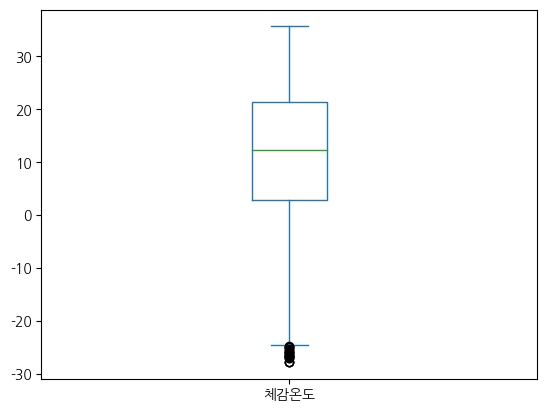

In [66]:
dropped_weather_df['체감온도'].plot(kind='box')
plt.show()

진짜 추운 날에는 영하 30도 근처까지 내려간다. 날도 춥고 칼바람 쌩쌩 부는 날인 모양이다.

#### 2-3-9. 일 단위로 집계

In [67]:
weather_daily_df = dropped_weather_df.groupby(['날짜', '지점'], as_index=False).agg({
    '강수여부': 'sum', '체감온도': 'mean', '기온(°C)': 'mean', '풍속(m/s)': 'mean'
})

weather_daily_df

,날짜,지점,강수여부,체감온도,기온(°C),풍속(m/s)
0,2022-01-01,116,0,-9.132250,-7.258333,3.987500
1,2022-01-01,400,0,-4.404167,-4.404167,0.708333
2,2022-01-01,401,0,-4.716667,-4.716667,1.000000
3,2022-01-01,402,0,-5.071994,-5.058333,0.991667
4,2022-01-01,403,0,-3.242531,-3.229167,1.141667
...,...,...,...,...,...,...
15275,2023-06-30,424,2,27.284616,24.791667,0.579167
15276,2023-06-30,425,1,26.947587,24.237500,0.658333
15277,2023-06-30,509,2,26.707166,24.126087,1.304167
15278,2023-06-30,510,1,28.194553,26.054167,0.979167


매번 여러 개 컬럼을 동시에 묶어서 groupby 할 때마다 멀티인덱스 때문에 짜증났었는데!! ```as_index = False```로 주면 **멀티인덱스가 안 생긴다**는 꿀팁을 알게 됐다...! 유레카다 유레카

In [68]:
weather_daily_df.isna().sum()

날짜            0
지점            0
강수여부          0
체감온도       1035
기온(°C)       12
풍속(m/s)       0
dtype: int64

#### 2-3-10. 위치 데이터 매핑

In [69]:
# 위치 정보를 담은 csv 파일 불러오기
weather_pos_df = pd.read_csv('META_관측지점정보_20231106165559.csv', encoding='cp949')
weather_pos_df

,지점,시작일,종료일,지점명,지점주소,관리관서,위도,경도,노장해발고도(m),기압계(관측장비지상높이(m)),기온계(관측장비지상높이(m)),풍속계(관측장비지상높이(m)),강우계(관측장비지상높이(m))
0,400,2020-10-23,NaN,강남,서울특별시 강남구일원동 580탄천 물재생센터,NaN,37.4982,127.0817,10.32,NaN,NaN,NaN,NaN
1,400,2019-05-29,2020-10-23,강남,서울특별시 강남구일원동 580탄천 물재생센터,NaN,37.4982,127.0816,28.70,NaN,NaN,NaN,NaN
2,400,2010-08-16,2019-05-29,강남,서울특별시 강남구일원동 580탄천 물재생센터,NaN,37.5134,127.0467,59.24,NaN,NaN,NaN,NaN
3,400,1994-12-04,2010-08-15,강남,서울특별시 강남구일원동 580탄천 물재생센터,서울기상관측소(108),37.5094,127.0485,59.00,NaN,NaN,NaN,NaN
4,401,2022-09-23,NaN,서초,서울특별시 서초구서초동 1416번지서초 IC,NaN,37.4846,127.0260,33.05,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,509,1992-09-14,2004-09-04,관악,서울특별시 관악구관악로 1서울대학교 대기환경관측소,서울기상관측소(108),37.4562,126.9507,92.36,NaN,NaN,NaN,NaN
79,510,2021-08-26,NaN,영등포,서울특별시 영등포구국회대로53길 20서울영동초등학교,NaN,37.5271,126.9071,25.38,NaN,NaN,NaN,NaN
80,510,2010-08-16,2021-08-26,영등포,서울특별시 영등포구국회대로53길 20서울영동초등학교,NaN,37.5271,126.9071,25.38,NaN,NaN,NaN,NaN
81,510,1989-06-27,2010-08-15,영등포,서울특별시 영등포구국회대로53길 20서울영동초등학교,서울기상관측소(108),37.5262,126.9080,25.00,NaN,NaN,NaN,NaN


쓸모없는 컬럼들이 보인다. 요긴하게 쓰일 컬럼은 지점, 종료일, 지점주소 정도일 것 같고 그 외에 정말 안 쓰일 것 같은 컬럼들은 드랍하는 게 유리하겠다.

In [70]:
dropped_weather_pos_df = weather_pos_df.drop([
    '관리관서', '노장해발고도(m)', '기압계(관측장비지상높이(m))', '기온계(관측장비지상높이(m))',
    '풍속계(관측장비지상높이(m))', '강우계(관측장비지상높이(m))'
], axis=1)

dropped_weather_pos_df

,지점,시작일,종료일,지점명,지점주소,위도,경도
0,400,2020-10-23,NaN,강남,서울특별시 강남구일원동 580탄천 물재생센터,37.4982,127.0817
1,400,2019-05-29,2020-10-23,강남,서울특별시 강남구일원동 580탄천 물재생센터,37.4982,127.0816
2,400,2010-08-16,2019-05-29,강남,서울특별시 강남구일원동 580탄천 물재생센터,37.5134,127.0467
3,400,1994-12-04,2010-08-15,강남,서울특별시 강남구일원동 580탄천 물재생센터,37.5094,127.0485
4,401,2022-09-23,NaN,서초,서울특별시 서초구서초동 1416번지서초 IC,37.4846,127.0260
...,...,...,...,...,...,...,...
78,509,1992-09-14,2004-09-04,관악,서울특별시 관악구관악로 1서울대학교 대기환경관측소,37.4562,126.9507
79,510,2021-08-26,NaN,영등포,서울특별시 영등포구국회대로53길 20서울영동초등학교,37.5271,126.9071
80,510,2010-08-16,2021-08-26,영등포,서울특별시 영등포구국회대로53길 20서울영동초등학교,37.5271,126.9071
81,510,1989-06-27,2010-08-15,영등포,서울특별시 영등포구국회대로53길 20서울영동초등학교,37.5262,126.9080


주소로부터 구를 추출한 파생 컬럼을 만들어 두면 추후 조인에 유리할 것이다.

In [71]:
dropped_weather_pos_df['지점주소'].isna().sum()

2

주소가 결측치인 건 신박한데...? 걔네들은 제외할 필요가 있겠다. 그리고 종료일이 기재되어 있는 지점은 현재 운영이 안 되고 있을 것이므로 **종료일이 결측치인 컬럼**만을 취해야만 한다.

In [72]:
weather_cur_pos_df = dropped_weather_pos_df[
    (dropped_weather_pos_df['지점주소'].notna()) & (dropped_weather_pos_df['종료일'].isna())
][['지점', '지점주소', '위도', '경도']].reset_index(drop=True)

weather_cur_pos_df

,지점,지점주소,위도,경도
0,400,서울특별시 강남구일원동 580탄천 물재생센터,37.4982,127.0817
1,401,서울특별시 서초구서초동 1416번지서초 IC,37.4846,127.0260
2,402,서울특별시 강동구고덕로 183서울종합직업전문학교,37.5555,127.1450
3,403,서울특별시 송파구올림픽로 240롯데월드,37.5115,127.0967
4,404,서울특별시 강서구양천로 201서남물재생센터,37.5739,126.8295
5,405,서울특별시 양천구 안양천로 917목동빗물펌프장(목동),37.5282,126.8794
6,406,서울특별시 도봉구시루봉로 173신방학초등학교,37.6661,127.0295
7,407,서울특별시 노원구공릉동 사서함 230-3호 사서함 77호 육군사관학교,37.6219,127.0919
8,408,서울특별시 동대문구서울시립대로 163 서울시립대학교 창공관,37.5846,127.0604
9,409,서울특별시 중랑구면목로57길 32면동초등학교,37.5855,127.0868


In [73]:
def process_address(txt):
    '''
    주소를 받아서 구를 반환하는 함수
    '''
    new_txt = txt.split(' ')[1]
    for i in range(1, 4):
        if new_txt[i] == '구':
            return new_txt[:(i + 1)]
    return None

weather_cur_pos_df['그룹명'] = weather_cur_pos_df['지점주소'].apply(process_address)
weather_cur_pos_df['그룹명'].value_counts()

관악구     2
영등포구    2
동작구     2
광진구     1
강북구     1
구로구     1
성동구     1
중구      1
금천구     1
은평구     1
용산구     1
성북구     1
강남구     1
서초구     1
마포구     1
중랑구     1
동대문구    1
노원구     1
도봉구     1
양천구     1
강서구     1
송파구     1
강동구     1
서대문구    1
Name: 그룹명, dtype: int64

관악구, 영등포구, 동작구는 **지점이 2개씩** 있어서 추후 처리가 필요할 듯하다.

아무튼 이제 관측 데이터와 지점 데이터를 합칠 수 있다.

In [74]:
merged_weather_df = pd.merge(
    left=weather_daily_df,
    right=weather_cur_pos_df,
    how='outer',
    on='지점'
)

merged_weather_df

,날짜,지점,강수여부,체감온도,기온(°C),풍속(m/s),지점주소,위도,경도,그룹명
0,2022-01-01,116,0,-9.132250,-7.258333,3.987500,NaN,NaN,NaN,NaN
1,2022-01-02,116,0,-5.185065,-3.808333,3.891667,NaN,NaN,NaN,NaN
2,2022-01-03,116,0,-5.417206,-4.962500,2.333333,NaN,NaN,NaN,NaN
3,2022-01-04,116,0,-7.591565,-6.154167,3.529167,NaN,NaN,NaN,NaN
4,2022-01-05,116,0,-4.916286,-4.525000,1.895833,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
15275,2023-06-26,889,11,27.503134,24.691667,1.262500,서울특별시 동작구현충로 210국립서울현충원,37.5004,126.9765,동작구
15276,2023-06-27,889,2,27.848212,25.895833,1.758333,서울특별시 동작구현충로 210국립서울현충원,37.5004,126.9765,동작구
15277,2023-06-28,889,0,29.147872,26.745833,1.354167,서울특별시 동작구현충로 210국립서울현충원,37.5004,126.9765,동작구
15278,2023-06-29,889,11,28.159810,24.812500,0.866667,서울특별시 동작구현충로 210국립서울현충원,37.5004,126.9765,동작구


잘 된 것 같은데 지점주소가 NaN인 데이터가 있다. 아마 지점이 매핑이 안 되는 곳인 것 같다.

In [75]:
merged_weather_df[merged_weather_df['지점주소'].isna()]['지점'].value_counts()

116    546
Name: 지점, dtype: int64

116 지점은 drop해버리는 게 좋겠다.

In [76]:
merged_dropped_weather_df = merged_weather_df[merged_weather_df['지점주소'].notna()]
merged_dropped_weather_df.isna().sum()

날짜            0
지점            0
강수여부          0
체감온도       1031
기온(°C)        8
풍속(m/s)       0
지점주소          0
위도            0
경도            0
그룹명           0
dtype: int64

그리고 아까 같은 구에 2개 들어가 있는 것들을 확인했었는데, 더 질이 좋은 하나만 쓰는 게 좋겠다.

In [77]:
for idx, df in merged_dropped_weather_df[merged_dropped_weather_df['그룹명'] == '관악구'].groupby('지점'):
    print('=' * 30)
    print(f"{idx} 지점의 결측치")
    print(df.isna().sum())

425 지점의 결측치
날짜         0
지점         0
강수여부       0
체감온도       0
기온(°C)     0
풍속(m/s)    0
지점주소       0
위도         0
경도         0
그룹명        0
dtype: int64
509 지점의 결측치
날짜           0
지점           0
강수여부         0
체감온도       153
기온(°C)       0
풍속(m/s)      0
지점주소         0
위도           0
경도           0
그룹명          0
dtype: int64


지점 509 drop하기

In [78]:
for idx, df in merged_dropped_weather_df[merged_dropped_weather_df['그룹명'] == '영등포구'].groupby('지점'):
    print('=' * 30)
    print(f"{idx} 지점의 결측치")
    print(df.isna().sum())

418 지점의 결측치
날짜         0
지점         0
강수여부       0
체감온도       0
기온(°C)     0
풍속(m/s)    0
지점주소       0
위도         0
경도         0
그룹명        0
dtype: int64
510 지점의 결측치
날짜         0
지점         0
강수여부       0
체감온도       1
기온(°C)     0
풍속(m/s)    0
지점주소       0
위도         0
경도         0
그룹명        0
dtype: int64


지점 510 drop하기

In [79]:
for idx, df in merged_dropped_weather_df[merged_dropped_weather_df['그룹명'] == '동작구'].groupby('지점'):
    print('=' * 30)
    print(f"{idx} 지점의 결측치")
    print(df.isna().sum())

410 지점의 결측치
날짜         0
지점         0
강수여부       0
체감온도       0
기온(°C)     0
풍속(m/s)    0
지점주소       0
위도         0
경도         0
그룹명        0
dtype: int64
889 지점의 결측치
날짜         0
지점         0
강수여부       0
체감온도       0
기온(°C)     0
풍속(m/s)    0
지점주소       0
위도         0
경도         0
그룹명        0
dtype: int64


지점 889 drop하기

In [80]:
processed_weather_df = merged_dropped_weather_df[
    (merged_dropped_weather_df['지점'] != 509) &
    (merged_dropped_weather_df['지점'] != 510) &
    (merged_dropped_weather_df['지점'] != 889)
].drop(['지점주소', '위도', '경도'], axis=1).reset_index(drop=True)

processed_weather_df

,날짜,지점,강수여부,체감온도,기온(°C),풍속(m/s),그룹명
0,2022-01-01,400,0,-4.404167,-4.404167,0.708333,강남구
1,2022-01-02,400,0,-0.257847,-0.233333,1.466667,강남구
2,2022-01-03,400,0,-1.579167,-1.579167,0.983333,강남구
3,2022-01-04,400,0,-0.554167,-0.554167,1.475000,강남구
4,2022-01-05,400,0,-2.187500,-2.187500,0.683333,강남구
...,...,...,...,...,...,...,...
13091,2023-06-26,425,11,25.555988,23.066667,0.979167,관악구
13092,2023-06-27,425,1,25.628431,24.091667,1.820833,관악구
13093,2023-06-28,425,0,26.881143,25.108333,1.337500,관악구
13094,2023-06-29,425,10,26.429259,23.516667,1.270833,관악구


#### 2-3-11. 데이터프레임 저장

In [81]:
with open('processed_weather_df.pkl', 'wb') as file:
    pickle.dump(processed_weather_df, file)
    print("저장 완료")

저장 완료


## 3. 가설 검정

이제부터 **야외 활동이 어려운 날씨일 때 자전거 이용건수가 유의미하게 감소하는지**(날씨 좋은 날에는 공공자전거 이용건수가 더 많은지) 확인해보도록 한다.

### 3-1. 데이터 로딩 및 전처리

In [82]:
with open('new_cycle_use_df.pkl', 'rb') as file:
    new_cycle_use_df = pickle.load(file)
    
new_cycle_use_df

,그룹명,대여소명,대여년월,대여건수,반납건수
0,양천구,729. 서부식자재마트 건너편,2022-07-01,107,126
1,양천구,731. 서울시 도로환경관리센터,2022-07-01,102,85
2,양천구,732. 신월중학교,2022-07-01,74,59
3,양천구,733. 신정이펜하우스314동,2022-07-01,36,17
4,양천구,734. 신트리공원 입구,2022-07-01,132,144
...,...,...,...,...,...
965407,마포구,426. 서울신용보증재단,2023-06-30,56,55
965408,양천구,722. 경서농협 버스정류장(우리은행신정동지점방향),2023-06-30,70,71
965409,양천구,723. SBS방송국,2023-06-30,109,110
965410,양천구,725. 양강중학교앞 교차로,2023-06-30,42,16


각 대여소별 이용건수는 대여건수와 반납건수를 합한 것으로 정한다.

In [83]:
new_cycle_use_df['이용건수'] = new_cycle_use_df['대여건수'] + new_cycle_use_df['반납건수']
new_cycle_use_df

,그룹명,대여소명,대여년월,대여건수,반납건수,이용건수
0,양천구,729. 서부식자재마트 건너편,2022-07-01,107,126,233
1,양천구,731. 서울시 도로환경관리센터,2022-07-01,102,85,187
2,양천구,732. 신월중학교,2022-07-01,74,59,133
3,양천구,733. 신정이펜하우스314동,2022-07-01,36,17,53
4,양천구,734. 신트리공원 입구,2022-07-01,132,144,276
...,...,...,...,...,...,...
965407,마포구,426. 서울신용보증재단,2023-06-30,56,55,111
965408,양천구,722. 경서농협 버스정류장(우리은행신정동지점방향),2023-06-30,70,71,141
965409,양천구,723. SBS방송국,2023-06-30,109,110,219
965410,양천구,725. 양강중학교앞 교차로,2023-06-30,42,16,58


In [84]:
with open('processed_weather_df.pkl', 'rb') as file:
    processed_weather_df = pickle.load(file)
    
processed_weather_df

,날짜,지점,강수여부,체감온도,기온(°C),풍속(m/s),그룹명
0,2022-01-01,400,0,-4.404167,-4.404167,0.708333,강남구
1,2022-01-02,400,0,-0.257847,-0.233333,1.466667,강남구
2,2022-01-03,400,0,-1.579167,-1.579167,0.983333,강남구
3,2022-01-04,400,0,-0.554167,-0.554167,1.475000,강남구
4,2022-01-05,400,0,-2.187500,-2.187500,0.683333,강남구
...,...,...,...,...,...,...,...
13091,2023-06-26,425,11,25.555988,23.066667,0.979167,관악구
13092,2023-06-27,425,1,25.628431,24.091667,1.820833,관악구
13093,2023-06-28,425,0,26.881143,25.108333,1.337500,관악구
13094,2023-06-29,425,10,26.429259,23.516667,1.270833,관악구


자전거 데이터와 날씨 데이터를 합친다.

In [85]:
merged_df = pd.merge(
    left=new_cycle_use_df,
    right=processed_weather_df,
    how='left',
    left_on=['그룹명', '대여년월'],
    right_on=['그룹명', '날짜']
)

merged_df

,그룹명,대여소명,대여년월,대여건수,반납건수,이용건수,날짜,지점,강수여부,체감온도,기온(°C),풍속(m/s)
0,양천구,729. 서부식자재마트 건너편,2022-07-01,107,126,233,2022-07-01,405.0,0.0,NaN,27.520833,1.195833
1,양천구,731. 서울시 도로환경관리센터,2022-07-01,102,85,187,2022-07-01,405.0,0.0,NaN,27.520833,1.195833
2,양천구,732. 신월중학교,2022-07-01,74,59,133,2022-07-01,405.0,0.0,NaN,27.520833,1.195833
3,양천구,733. 신정이펜하우스314동,2022-07-01,36,17,53,2022-07-01,405.0,0.0,NaN,27.520833,1.195833
4,양천구,734. 신트리공원 입구,2022-07-01,132,144,276,2022-07-01,405.0,0.0,NaN,27.520833,1.195833
...,...,...,...,...,...,...,...,...,...,...,...,...
965407,마포구,426. 서울신용보증재단,2023-06-30,56,55,111,2023-06-30,411.0,1.0,28.148547,25.475000,1.737500
965408,양천구,722. 경서농협 버스정류장(우리은행신정동지점방향),2023-06-30,70,71,141,2023-06-30,405.0,2.0,27.723952,25.520833,1.300000
965409,양천구,723. SBS방송국,2023-06-30,109,110,219,2023-06-30,405.0,2.0,27.723952,25.520833,1.300000
965410,양천구,725. 양강중학교앞 교차로,2023-06-30,42,16,58,2023-06-30,405.0,2.0,27.723952,25.520833,1.300000


In [86]:
merged_grouped_df = merged_df.groupby(['그룹명', '대여년월'], as_index=False).agg(
    {'이용건수': 'sum', '강수여부': 'sum', '체감온도': 'mean', '기온(°C)': 'mean', '풍속(m/s)': 'mean'}
)

merged_grouped_df

,그룹명,대여년월,이용건수,강수여부,체감온도,기온(°C),풍속(m/s)
0,강남구,2022-07-01,9216,0.0,28.836093,27.091667,1.137500
1,강남구,2022-07-02,7001,0.0,30.295450,29.416667,0.875000
2,강남구,2022-07-03,6071,0.0,30.430997,29.937500,0.920833
3,강남구,2022-07-04,8079,153.0,30.733099,29.745833,0.812500
4,강남구,2022-07-05,8365,0.0,30.671257,29.470833,0.791667
...,...,...,...,...,...,...,...
9095,중랑구,2023-06-25,8395,0.0,28.588273,28.333333,1.725000
9096,중랑구,2023-06-27,10158,279.0,26.690446,25.970833,2.558333
9097,중랑구,2023-06-28,10871,0.0,28.101424,27.079167,2.233333
9098,중랑구,2023-06-29,2130,1116.0,27.160036,24.616667,2.366667


강수여부를 무식하게 ```sum```으로 구했더니 뭔 1116 이런다 ㅋㅋㅋㅋㅋ

1이나 1116이나 어쨌든 그 날 비 온 건 똑같으니까 binary형 변수가 필요하다.

In [87]:
merged_grouped_df['강수여부(b)'] = merged_grouped_df['강수여부'].apply(lambda x: 1 if x > 0 else 0)
merged_grouped_df['강수여부(b)'].value_counts()

0    7040
1    2060
Name: 강수여부(b), dtype: int64

이제 대략적인 준비는 끝난 것 같다.

In [88]:
merged_grouped_df[['이용건수', '강수여부(b)', '체감온도', '기온(°C)', '풍속(m/s)']].corr()

,이용건수,강수여부(b),체감온도,기온(°C),풍속(m/s)
이용건수,1.000000,-0.156352,0.289238,0.339025,-0.043079
강수여부(b),-0.156352,1.000000,0.276369,0.256534,0.093945
체감온도,0.289238,0.276369,1.000000,0.997988,-0.068080
기온(°C),0.339025,0.256534,0.997988,1.000000,-0.079164
풍속(m/s),-0.043079,0.093945,-0.068080,-0.079164,1.000000


간략하게 correlation matrix를 그려봤는데 체감온도, 기온은 약간의 상관관계가 있는 것 같다.

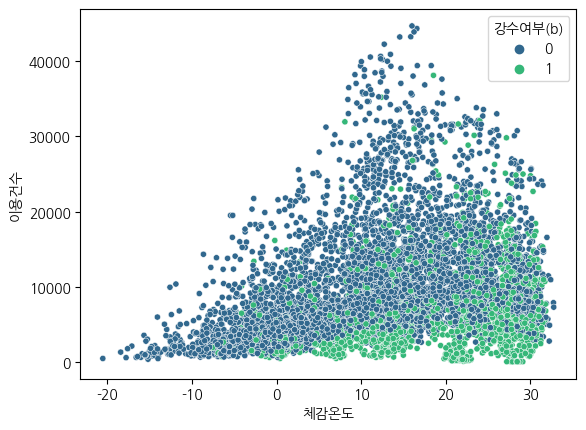

In [89]:
sns.scatterplot(x='체감온도', y='이용건수', hue='강수여부(b)', data=merged_grouped_df, palette='viridis', s=20)
plt.show()

10~20도 선에서는 올라가는 추세고 그 이후엔 내려가는 추세인 것도 같다?

### 3-2. 가설 검정 (날씨가 좋은 날)

#### 3-2-1. 가설 설정

'날씨가 좋은 날'의 기준은 다음을 모두 만족하는 날로 정한다.
- 하루 평균 체감온도가 10도 이상, 25도 이하인 날
- 하루 중 강수가 전혀 없는 날

이제 귀무가설과 대립가설을 다음과 같이 세울 수 있다.
- $H_0$: 날씨가 좋은 날의 '이용건수' 평균과 그 외의 날의 '이용건수' 평균 사이에는 차이가 없다.
- $H_1$: 날씨가 좋은 날의 '이용건수' 평균은 그 외의 날의 '이용건수' 평균보다 크다.

In [90]:
good_weather_df = merged_grouped_df[
    (merged_grouped_df['체감온도'] >= 10) & (merged_grouped_df['체감온도'] <= 25) &
    (merged_grouped_df['강수여부(b)'] == 0)
]

good_weather_df

,그룹명,대여년월,이용건수,강수여부,체감온도,기온(°C),풍속(m/s),강수여부(b)
58,강남구,2022-08-28,9795,0.0,23.159422,22.883333,0.783333,0
61,강남구,2022-08-31,9249,0.0,23.891081,21.541667,0.475000,0
68,강남구,2022-09-07,10414,0.0,23.299635,22.725000,0.808333,0
69,강남구,2022-09-08,10210,0.0,23.613166,22.729167,0.547826,0
70,강남구,2022-09-09,7276,0.0,24.752734,24.012500,0.553333,0
...,...,...,...,...,...,...,...,...
9082,중랑구,2023-06-12,10755,0.0,23.793772,23.225000,1.429167,0
9083,중랑구,2023-06-13,11976,0.0,23.431976,23.200000,1.958333,0
9085,중랑구,2023-06-15,12013,0.0,23.662027,23.216667,1.666667,0
9086,중랑구,2023-06-16,11947,0.0,24.701112,24.716667,2.020833,0


In [91]:
not_good_weather_df = merged_grouped_df[
    (merged_grouped_df['체감온도'] < 10) | (merged_grouped_df['체감온도'] > 25) |
    (merged_grouped_df['강수여부(b)'] == 1)
]

not_good_weather_df

,그룹명,대여년월,이용건수,강수여부,체감온도,기온(°C),풍속(m/s),강수여부(b)
0,강남구,2022-07-01,9216,0.0,28.836093,27.091667,1.137500,0
1,강남구,2022-07-02,7001,0.0,30.295450,29.416667,0.875000,0
2,강남구,2022-07-03,6071,0.0,30.430997,29.937500,0.920833,0
3,강남구,2022-07-04,8079,153.0,30.733099,29.745833,0.812500,1
4,강남구,2022-07-05,8365,0.0,30.671257,29.470833,0.791667,0
...,...,...,...,...,...,...,...,...
9095,중랑구,2023-06-25,8395,0.0,28.588273,28.333333,1.725000,0
9096,중랑구,2023-06-27,10158,279.0,26.690446,25.970833,2.558333,1
9097,중랑구,2023-06-28,10871,0.0,28.101424,27.079167,2.233333,0
9098,중랑구,2023-06-29,2130,1116.0,27.160036,24.616667,2.366667,1


#### 3-2-2. 정규성 검정

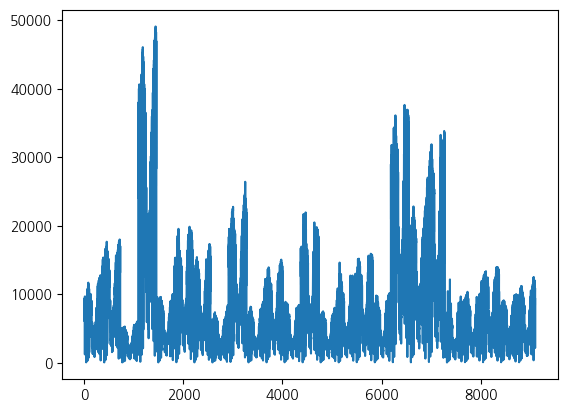

In [92]:
merged_grouped_df['이용건수'].plot(kind='line')
plt.show()

Q-Q plot이니 Shapiro-Wilk 정규성 검정이니 안 해봐도 대충 그래프 찍어보니까 정규성이 너무 없어 보인다... 굳이 여기서 정규성 검정을 더 들어가는 건 시간 낭비일 것 같으니 과감히 생략한다.

#### 3-2-3. 비모수적 검정

정규성 안 따르는 표본이면 비모수적 검정을 해야 한다. Mann-Whitney U 검정을 수행한다.

In [93]:
_, p_value_orders = stats.mannwhitneyu(good_weather_df['이용건수'], not_good_weather_df['이용건수'])

print("유의한 차이가 있음" if p_value_orders < 0.05 else "차이가 없음")

유의한 차이가 있음


In [94]:
good_weather_df['이용건수'].mean() - not_good_weather_df['이용건수'].mean()

5090.483438842621

날씨가 좋은 날의 이용건수와 그 외의 날의 이용건수 사이에 유의한 차이가 있다는 결론을 얻었다. 날씨가 좋은 날의 이용건수 평균이 훨씬 높기 때문에, **날씨가 좋은 날에 공공자전거를 더 많이 이용한다**는 결론을 얻을 수 있다.

사실 그리 놀라운 결과는 아니다. 날씨가 좋은 날에는 당연히 자전거를 더 많이 탈 것이다. 근데 이게 순전히 온도 차이에 의한 것인지, 혹은 강수 여부에 의한 것인지는 아직 모르겠다. 각각을 분리해서 확인해 보면 확실해질 것이다.

### 3-3. 가설 검정 (비오는 날)

#### 3-3-1. 가설 설정

이번에는 '비오는 날'과 그렇지 않은 날을 비교해 본다.
- 하루 중 강수가 있는 날

이제 귀무가설과 대립가설을 다음과 같이 세울 수 있다.
- $H_0$: 비오는 날의 '이용건수' 평균과 비 안 오는 날의 '이용건수' 평균 사이에는 차이가 없다.
- $H_1$: 비오는 날의 '이용건수' 평균은 비 안 오는 날의 '이용건수' 평균보다 크다.

In [95]:
rainy_weather_df = merged_grouped_df[
    (merged_grouped_df['강수여부(b)'] == 1)
]

rainy_weather_df

,그룹명,대여년월,이용건수,강수여부,체감온도,기온(°C),풍속(m/s),강수여부(b)
3,강남구,2022-07-04,8079,153.0,30.733099,29.745833,0.812500,1
5,강남구,2022-07-06,7549,152.0,31.140091,29.800000,1.154167,1
6,강남구,2022-07-07,6122,304.0,30.727484,28.604167,1.479167,1
7,강남구,2022-07-08,8733,154.0,28.757071,27.112500,1.562500,1
12,강남구,2022-07-13,1194,2384.0,27.527590,24.662500,1.300000,1
...,...,...,...,...,...,...,...,...
9091,중랑구,2023-06-21,4497,1023.0,22.787718,20.354167,1.737500,1
9092,중랑구,2023-06-22,10663,93.0,23.733012,22.658333,1.800000,1
9096,중랑구,2023-06-27,10158,279.0,26.690446,25.970833,2.558333,1
9098,중랑구,2023-06-29,2130,1116.0,27.160036,24.616667,2.366667,1


In [96]:
not_rainy_weather_df = merged_grouped_df[
    (merged_grouped_df['강수여부(b)'] == 0)
]

not_rainy_weather_df

,그룹명,대여년월,이용건수,강수여부,체감온도,기온(°C),풍속(m/s),강수여부(b)
0,강남구,2022-07-01,9216,0.0,28.836093,27.091667,1.137500,0
1,강남구,2022-07-02,7001,0.0,30.295450,29.416667,0.875000,0
2,강남구,2022-07-03,6071,0.0,30.430997,29.937500,0.920833,0
4,강남구,2022-07-05,8365,0.0,30.671257,29.470833,0.791667,0
8,강남구,2022-07-09,7463,0.0,29.087924,27.504167,1.060870,0
...,...,...,...,...,...,...,...,...
9089,중랑구,2023-06-19,10931,0.0,28.374277,28.845833,1.983333,0
9093,중랑구,2023-06-23,11661,0.0,25.363608,24.304167,1.550000,0
9094,중랑구,2023-06-24,10037,0.0,27.407748,26.975000,1.704167,0
9095,중랑구,2023-06-25,8395,0.0,28.588273,28.333333,1.725000,0


#### 3-3-2. 비모수적 검정

아까 정규성 안 따르는 표본인 거 봤으니까 이번에도 비모수적 검정을 수행한다. 마찬가지로 Mann-Whitney U 검정을 수행한다.

In [97]:
_, p_value_orders = stats.mannwhitneyu(rainy_weather_df['이용건수'], not_rainy_weather_df['이용건수'])

print("유의한 차이가 있음" if p_value_orders < 0.05 else "차이가 없음")

유의한 차이가 있음


In [98]:
rainy_weather_df['이용건수'].mean() - not_rainy_weather_df['이용건수'].mean()

-2879.6071670895853

비오는 날의 이용건수와 비 안 오는 날의 이용건수 사이에 유의한 차이가 있다는 결론을 얻었다. 비 안 오는 날의 이용건수 평균이 훨씬 높기 때문에, **비오는 날에 공공자전거를 더 적게 이용한다**는 결론을 얻을 수 있다.

### 3-4. 가설 검정 (적정 온도인 날)

#### 3-4-1. 가설 설정

이번에는 '적정 온도인 날'과 그렇지 않은 날을 비교해 본다.
- 하루 평균 체감온도가 10도 이상, 25도 이하인 날

이제 귀무가설과 대립가설을 다음과 같이 세울 수 있다.
- $H_0$: 적정 온도인 날의 '이용건수' 평균과 그렇지 않은 날의 '이용건수' 평균 사이에는 차이가 없다.
- $H_1$: 적정 온도인 날의 '이용건수' 평균은 그렇지 않은 날의 '이용건수' 평균보다 크다.

In [99]:
good_temperature_df = merged_grouped_df[
    (merged_grouped_df['체감온도'] >= 10) & (merged_grouped_df['체감온도'] <= 25)
]

good_temperature_df

,그룹명,대여년월,이용건수,강수여부,체감온도,기온(°C),풍속(m/s),강수여부(b)
55,강남구,2022-08-25,7241,318.0,24.340002,22.504167,0.733333,1
57,강남구,2022-08-27,10352,160.0,23.149309,23.050000,1.675000,1
58,강남구,2022-08-28,9795,0.0,23.159422,22.883333,0.783333,0
59,강남구,2022-08-29,6226,795.0,22.792190,21.112500,0.920833,1
60,강남구,2022-08-30,865,2580.0,22.077050,19.104167,0.612500,1
...,...,...,...,...,...,...,...,...
9085,중랑구,2023-06-15,12013,0.0,23.662027,23.216667,1.666667,0
9086,중랑구,2023-06-16,11947,0.0,24.701112,24.716667,2.020833,0
9087,중랑구,2023-06-17,9930,0.0,24.738901,25.466667,1.520833,0
9091,중랑구,2023-06-21,4497,1023.0,22.787718,20.354167,1.737500,1


In [100]:
not_good_temperature_df = merged_grouped_df[
    (merged_grouped_df['체감온도'] < 10) | (merged_grouped_df['체감온도'] > 25)
]

not_good_temperature_df

,그룹명,대여년월,이용건수,강수여부,체감온도,기온(°C),풍속(m/s),강수여부(b)
0,강남구,2022-07-01,9216,0.0,28.836093,27.091667,1.137500,0
1,강남구,2022-07-02,7001,0.0,30.295450,29.416667,0.875000,0
2,강남구,2022-07-03,6071,0.0,30.430997,29.937500,0.920833,0
3,강남구,2022-07-04,8079,153.0,30.733099,29.745833,0.812500,1
4,강남구,2022-07-05,8365,0.0,30.671257,29.470833,0.791667,0
...,...,...,...,...,...,...,...,...
9095,중랑구,2023-06-25,8395,0.0,28.588273,28.333333,1.725000,0
9096,중랑구,2023-06-27,10158,279.0,26.690446,25.970833,2.558333,1
9097,중랑구,2023-06-28,10871,0.0,28.101424,27.079167,2.233333,0
9098,중랑구,2023-06-29,2130,1116.0,27.160036,24.616667,2.366667,1


#### 3-4-2. 비모수적 검정

아까 정규성 안 따르는 표본인 거 봤으니까 이번에도 비모수적 검정을 수행한다. 마찬가지로 Mann-Whitney U 검정을 수행한다.

In [101]:
_, p_value_orders = stats.mannwhitneyu(good_temperature_df['이용건수'], not_good_temperature_df['이용건수'])

print("유의한 차이가 있음" if p_value_orders < 0.05 else "차이가 없음")

유의한 차이가 있음


In [102]:
good_temperature_df['이용건수'].mean() - not_good_temperature_df['이용건수'].mean()

4268.281013749446

적정 온도인 날의 이용건수와 그렇지 않은 날의 이용건수 사이에 유의한 차이가 있다는 결론을 얻었다. 적정 온도인 날의 이용건수 평균이 훨씬 높기 때문에, **적정 온도인 날에 공공자전거를 더 많이 이용한다**는 결론을 얻을 수 있다.

### 3-5. 가설 검정 (혹서기)

#### 3-5-1. 가설 설정

이번에는 '폭염인 날'과 그렇지 않은 날을 비교해 본다.
- 하루 평균 체감온도가 30도 이상인 날

이제 귀무가설과 대립가설을 다음과 같이 세울 수 있다.
- $H_0$: 폭염인 날의 '이용건수' 평균과 그렇지 않은 날의 '이용건수' 평균 사이에는 차이가 없다.
- $H_1$: 폭염인 날의 '이용건수' 평균은 그렇지 않은 날의 '이용건수' 평균보다 작다.

In [107]:
burning_df = merged_grouped_df[
    (merged_grouped_df['체감온도'] >= 30)
]

burning_df

,그룹명,대여년월,이용건수,강수여부,체감온도,기온(°C),풍속(m/s),강수여부(b)
1,강남구,2022-07-02,7001,0.0,30.295450,29.416667,0.875000,0
2,강남구,2022-07-03,6071,0.0,30.430997,29.937500,0.920833,0
3,강남구,2022-07-04,8079,153.0,30.733099,29.745833,0.812500,1
4,강남구,2022-07-05,8365,0.0,30.671257,29.470833,0.791667,0
5,강남구,2022-07-06,7549,152.0,31.140091,29.800000,1.154167,1
...,...,...,...,...,...,...,...,...
8771,중랑구,2022-08-05,8008,0.0,30.869635,29.754167,1.866667,0
8772,중랑구,2022-08-06,6985,186.0,30.933715,29.333333,1.550000,1
8773,중랑구,2022-08-07,6065,93.0,31.017504,29.541667,2.270833,1
8781,중랑구,2022-08-15,4823,186.0,30.207477,28.641667,3.508333,1


In [108]:
not_burning_df = merged_grouped_df[
    (merged_grouped_df['체감온도'] < 30)
]

not_burning_df

,그룹명,대여년월,이용건수,강수여부,체감온도,기온(°C),풍속(m/s),강수여부(b)
0,강남구,2022-07-01,9216,0.0,28.836093,27.091667,1.137500,0
7,강남구,2022-07-08,8733,154.0,28.757071,27.112500,1.562500,1
8,강남구,2022-07-09,7463,0.0,29.087924,27.504167,1.060870,0
10,강남구,2022-07-11,7532,0.0,28.581314,27.454167,1.300000,0
11,강남구,2022-07-12,9624,0.0,28.348606,27.337500,0.870833,0
...,...,...,...,...,...,...,...,...
9095,중랑구,2023-06-25,8395,0.0,28.588273,28.333333,1.725000,0
9096,중랑구,2023-06-27,10158,279.0,26.690446,25.970833,2.558333,1
9097,중랑구,2023-06-28,10871,0.0,28.101424,27.079167,2.233333,0
9098,중랑구,2023-06-29,2130,1116.0,27.160036,24.616667,2.366667,1


#### 3-5-2. 비모수적 검정

아까 정규성 안 따르는 표본인 거 봤으니까 이번에도 비모수적 검정을 수행한다. 마찬가지로 Mann-Whitney U 검정을 수행한다.

In [109]:
_, p_value_orders = stats.mannwhitneyu(good_temperature_df['이용건수'], not_good_temperature_df['이용건수'])

print("유의한 차이가 있음" if p_value_orders < 0.05 else "차이가 없음")

유의한 차이가 있음


In [110]:
burning_df['이용건수'].mean() - not_burning_df['이용건수'].mean()

-537.3952307319141

폭염인 날의 이용건수와 그렇지 않은 날의 이용건수 사이에 유의한 차이가 있다는 결론을 얻었다. 폭염인 날의 이용건수 평균이 훨씬 낮기 때문에, **폭염이 아닌 날에 공공자전거를 더 많이 이용한다**는 결론을 얻을 수 있다.

## 4. 결론

이상의 분석 결과로부터, 적정 온도 범위 내, 강수가 없는 환경에서의 공공자전거 이용건수가 유의미하게 많음을 확인할 수 있었다.

API를 핸들링하는 부분부터 파생변수를 생성하여 분석에 이용하는 부분까지 폭넓게 다뤄볼 수 있는 프로젝트였다. 여러 개의 데이터셋을 조인하여 활용해야만 했기에 해당 과업에서의 스킬들을 익힐 수 있었던 점도 좋았다.

다만 정규분포를 안 따르는 데이터라서 비모수적 검정을 활용해야 했던 부분이 조금 아쉽다.

또한 악천후의 기준에 대해 어떻게 정의내릴지를 내가 임의로 판단해서 분석을 진행했는데, 관련 연구를 추가로 서칭하여 기준이 될 만한 수치들을 확인해 보는 과정이 선행되었다면 더 정교한 결과를 얻을 수 있었을 것 같아 아쉽다.